In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mai 30

@author: yaning
"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)
from PIL import Image

2025-09-24 10:26:17.389780: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-24 10:26:17.423561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-24 10:26:18.115997: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
imgs = []

img = Image.open("datasets/pix/one_0.png")

# Convert to grayscale (optional)
img_gray = img.convert("L")  # 'L' = 8-bit grayscale
imgs.append(img_gray)

img = Image.open("datasets/pix/one_10.png")

# Convert to grayscale (optional)
img_gray = img.convert("L")  # 'L' = 8-bit grayscale
imgs.append(img_gray)

img = Image.open("datasets/pix/one_45.png")

# Convert to grayscale (optional)
img_gray = img.convert("L")  # 'L' = 8-bit grayscale
imgs.append(img_gray)

img = Image.open("datasets/pix/one_90.png")

# Convert to grayscale (optional)
img_gray = img.convert("L")  # 'L' = 8-bit grayscale
imgs.append(img_gray)

img = Image.open("datasets/pix/one_100.png")

# Convert to grayscale (optional)
img_gray = img.convert("L")  # 'L' = 8-bit grayscale
imgs.append(img_gray)

img = Image.open("datasets/pix/one_170.png")

# Convert to grayscale (optional)
img_gray = img.convert("L")  # 'L' = 8-bit grayscale
imgs.append(img_gray)


img = Image.open("datasets/pix/new.png")

# Convert to grayscale (optional)
img_gray = img.convert("L")  # 'L' = 8-bit grayscale
imgs.append(img_gray)



In [3]:
imgs = np.array(imgs)

In [4]:
imgs.shape

(7, 28, 28)

In [5]:
imgs = 1 - imgs / 255.0

In [6]:
imgs.shape

(7, 28, 28)

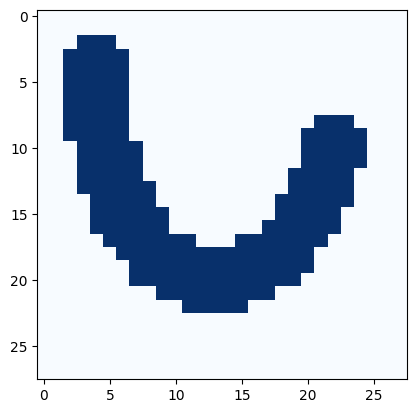

In [7]:
plt.imshow(imgs[6], cmap='Blues')

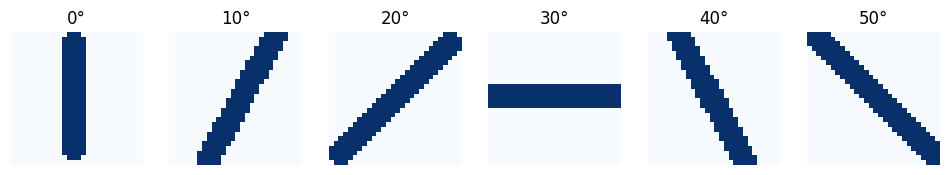

In [8]:
plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(imgs[i], cmap='Blues')
    plt.title(f"{int(10*i)}°")
    plt.axis('off')
plt.show()

normalise them independently and also keep the 0/pure-black ones zeros

if not the zeros will be around 0.5 after normalisation but there should be no information at all

In [9]:
# only normalise non-zero ones 
def normalise_non_zero(feature_maps):
    data_norm = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[0]):
        img = feature_maps[i]
        non_zero_mask = img != 0
        img = img[non_zero_mask]
        img_min = img.min()
        img_max = img.max()
        if img_max > img_min:
            data_norm[i][non_zero_mask] = (img - img_min) / (img_max - img_min)
        else:
            data_norm[i] = 0
    return data_norm

# normalise everything
def normalise(feature_maps):
    data_norm = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[0]):
        img = feature_maps[i]
        img_min = img.min()
        img_max = img.max()
        if img_max > img_min:
            data_norm[i] = (img - img_min) / (img_max - img_min)
        else:
            data_norm[i] = 0
    return data_norm

In [10]:
# size=7, sigma=2.0, Lambda=3.0, psi=0, gamma=0.5, theta=0
def gabor_kernel(size=4, sigma=4.0, Lambda=10.0, psi=0.5, gamma=1, theta=0):
    """Generate a 2D Gabor filter kernel."""
    half = size // 2
    y, x = np.meshgrid(range(-half, half+1), range(-half, half+1))
    x_theta = x * np.cos(theta) + y * np.sin(theta) + 1
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    gb = np.exp(-0.5 * (x_theta**2 + (gamma**2) * y_theta**2) / (sigma**2)) * np.cos(2 * np.pi * x_theta / Lambda + psi)
    return gb

# Generate 6 filters rotated from 0 to 360
angles = np.deg2rad(np.arange(0, 360, 45))
filters = np.stack([gabor_kernel(theta=angle) for angle in angles], axis=-1)  # shape (size, size, 6)

# Conv2D weights shape: (kernel_h, kernel_w, input_channels, output_channels)
filters = filters[:, :, np.newaxis, :]  # add input channel dim = 1

# Normalize filters to zero mean and unit norm (optional)
filters -= filters.mean(axis=(0,1), keepdims=True)
filters /= np.linalg.norm(filters, axis=(0,1), keepdims=True) + 1e-10

In [11]:
imgs = imgs.reshape(7,28,28,1)

In [12]:
gabor_data = []
for pic in imgs:
    img = np.expand_dims(pic, axis=0)
    feature_maps = tf.nn.conv2d(img, filters, strides=3, padding='SAME')
    gabor_data.append(feature_maps[0])

I0000 00:00:1758702388.964950 2275751 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22028 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-09-24 10:26:29.192324: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


In [13]:
gabor_data = np.array(gabor_data)

In [14]:
gabor_data.shape

(7, 10, 10, 8)

In [15]:
normalised_gabor_data = normalise_non_zero(gabor_data)

In [16]:
normalised_gabor_data.shape

(7, 10, 10, 8)

In [17]:
normalised_gabor_data = np.where(normalised_gabor_data > 0.5, 1, 0)

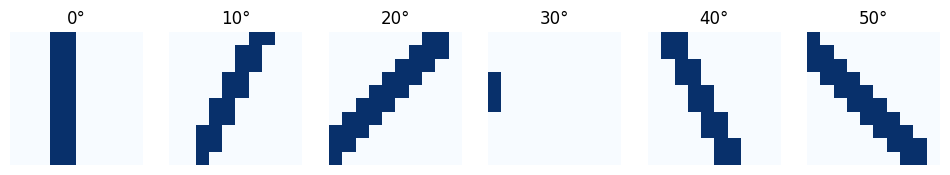

In [18]:
plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(normalised_gabor_data[i, :, :, 6], cmap='Blues')
    plt.title(f"{int(10*i)}°")
    plt.axis('off')
plt.show()

In [19]:
normalised_gabor_data.shape

(7, 10, 10, 8)

In [20]:
# form an shape (5000, 3) array with 5000 time points and 3 input neurons
# every fire is 45-50 cycles, 
pointCount = 6000
start_tstep = 500
one_cycle = np.concatenate((np.ones(45, dtype=bool), np.zeros(189, dtype=bool)))
# one_cycle = np.ones(234)
firing_duration = 45+189
# 23*(45+189) = 5382
total_time = 5382


non_fire_array = np.zeros(pointCount, dtype=bool)

fire_seq = np.tile(one_cycle, 23)
fire_array = non_fire_array.copy()
fire_array[start_tstep:start_tstep+len(fire_seq)] = fire_seq

In [26]:
np.concatenate([fire_array,fire_array]).shape

(12000,)

In [28]:
fire_data = np.zeros((7,10,10,8,12000), dtype=bool)
for i in range(normalised_gabor_data.shape[0]):
    for x in range(normalised_gabor_data.shape[1]):
        for y in range(normalised_gabor_data.shape[2]):
            for z in range(normalised_gabor_data.shape[3]):
                if normalised_gabor_data[i,x,y,z] == 0:
                    fire_data[i,x,y,z] = np.concatenate([non_fire_array,non_fire_array])
                else:
                    fire_data[i,x,y,z] = np.concatenate([fire_array,fire_array])

In [29]:
fire_data.shape

(7, 10, 10, 8, 12000)

In [49]:
fire_data = fire_data.reshape(10,10,8,6300)

In [30]:
import pickle
path = "/home/yaning/Documents/"

with open(path + "fire_data_gabor_binary_rotate_12000.pkl", "wb") as f:
    pickle.dump(fire_data, f)